In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
# Parámetros fijos
T_Y = 0.8
epsilon = 1.5 
gamma = 1.0
n_steps = int(1e5)
state_labels = [(0,0), (0,1), (1,0), (1,1)]
cycle_states = [0, 2, 3, 1]

# Matriz de energías
def energy(x, y, epsilon):
    return 0 if x == y else epsilon

# Transiciones permitidas
transitions = [
    (0, 1, 'Y', 1),
    (0, 2, 'X', 1),
    (1, 0, 'Y', 1),
    (1, 3, 'X', 1),
    (2, 0, 'X', 1),
    (2, 3, 'Y', 1),
    (3, 1, 'X', 1),
    (3, 2, 'Y', 1),
]

def rate(i, j, epsilon):
    x1, y1 = state_labels[i]
    x2, y2 = state_labels[j]
    if x1 != x2:  # salto en X
        deltaE = energy(x2, y2, epsilon) - energy(x1, y1, epsilon)
        T = T_X
    else:         # salto en Y
        deltaE = energy(x2, y2, epsilon) - energy(x1, y1, epsilon)
        T = T_Y
    if deltaE <= 0:
        return gamma
    else:
        return gamma * np.exp(-deltaE / T)

# Barrido de T_X
T_X_vals = np.linspace(0.1, 4.0, 100)

I_dot_X_vals = []
eff_info_vals = []
S_env_vals = []
S_env_X_vals = []
S_env_Y_vals = []
currents = []
eff_X_vals = []
eff_Y_vals = []

for T_X in T_X_vals:
    # Inicialización
    state = 0
    time = 0.0
    states_count = np.zeros(4)
    cycle_count = 0
    for step in range(n_steps):
        rates = []
        dests = []
        for t in transitions:
            if t[0] == state:
                r = rate(t[0], t[1], epsilon)
                rates.append(r)
                dests.append(t[1])
        rates = np.array(rates)
        total_rate = rates.sum()
        if total_rate == 0:
            break
        dt = np.random.exponential(1.0 / total_rate)
        time += dt
        choice = np.random.choice(len(dests), p=rates/total_rate)
        next_state = dests[choice]
        states_count[state] += dt
        idx_in_cycle = cycle_states.index(state)
        next_idx_in_cycle = cycle_states.index(next_state)
        if (idx_in_cycle + 1) % 4 == next_idx_in_cycle:
            cycle_count += 1
        elif (idx_in_cycle - 1) % 4 == next_idx_in_cycle:
            cycle_count -= 1
        state = next_state
    prob_steady = states_count / states_count.sum()
    
    # Análisis informacional
    p_joint = prob_steady.copy()
    p_X = np.zeros(2)
    p_Y = np.zeros(2)
    for idx, (x, y) in enumerate(state_labels):
        p_X[x] += p_joint[idx]
        p_Y[y] += p_joint[idx]
    I_dot_X = 0.0
    S_env = 0.0
    S_env_X = 0.0
    S_env_Y = 0.0
    for t in transitions:
        i, j, salto, _ = t
        x1, y1 = state_labels[i]
        x2, y2 = state_labels[j]
        W_ij = rate(i, j, epsilon)
        W_ji = rate(j, i, epsilon)
        p_i = prob_steady[i]
        p_j = prob_steady[j]
        if W_ij > 0 and p_i > 0 and W_ji > 0 and p_j > 0:
            contrib = W_ij * p_i * np.log(W_ij / W_ji)
            if salto == 'X':
                S_env_X += contrib
                if p_X[x1] > 0 and p_X[x2] > 0:
                    py_x1 = p_joint[i] / p_X[x1]
                    py_x2 = p_joint[j] / p_X[x2]
                    if py_x1 > 0 and py_x2 > 0:
                        I_dot_X += W_ij * p_i * np.log(py_x2 / py_x1)
            elif salto == 'Y':
                S_env_Y += contrib
            S_env += W_ij * p_i * np.log(W_ij / W_ji)
            
    corriente_ciclo = cycle_count / time
    I_dot_X_vals.append(I_dot_X)
    S_env_vals.append(S_env)
    S_env_X_vals.append(S_env_X)
    S_env_Y_vals.append(S_env_Y)
    eff_info_vals.append(abs(I_dot_X) / abs(S_env) if S_env != 0 else 0)
    currents.append(corriente_ciclo)
    eff_X = I_dot_X / S_env_X if S_env_X != 0 else 0
    eff_Y = abs(S_env_Y) / I_dot_X if I_dot_X != 0 else 0
    eff_X_vals.append(eff_X)
    eff_Y_vals.append(eff_Y)    
    

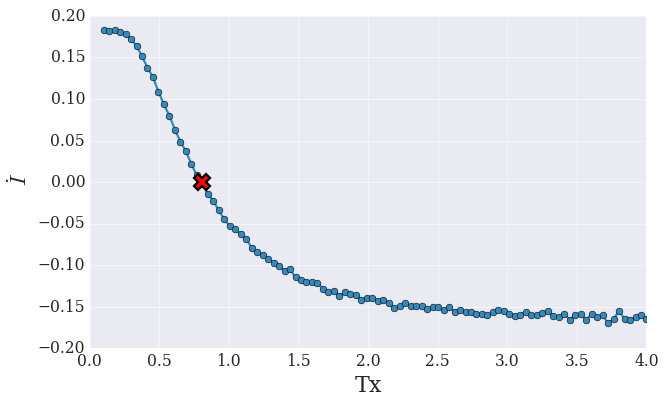

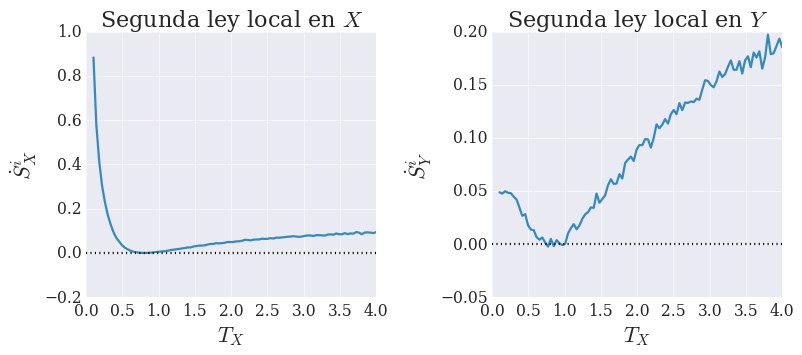

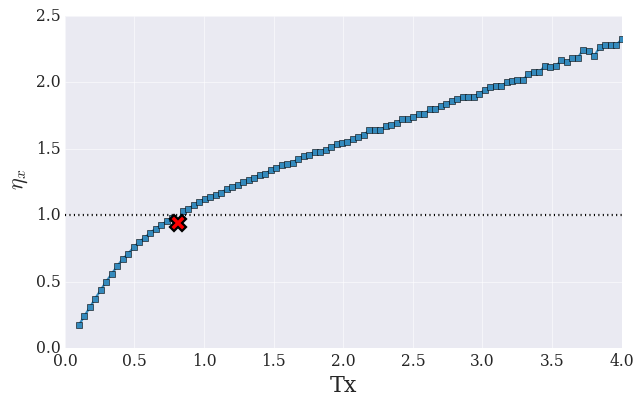

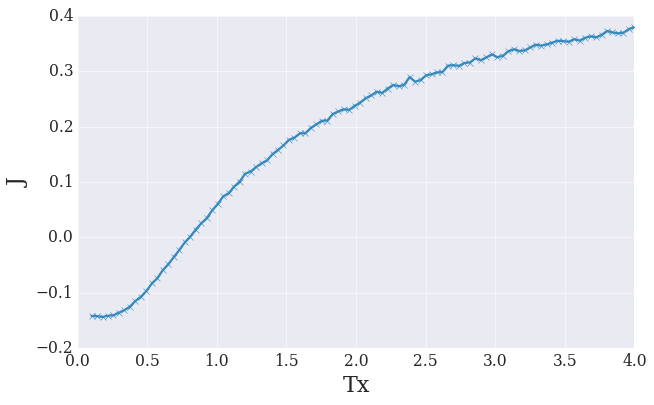

In [43]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 20,
    'font.family': 'serif',
    'figure.figsize': (8, 5)
})

# Encontrar índice del valor más cercano a Tx = 0.8
idx_closest_to_Ty = np.argmin(np.abs(T_X_vals - 0.8))



# Figura 1: Flujo de información
plt.figure()
plt.plot(T_X_vals, I_dot_X_vals, marker='o')
plt.xlabel('Tx')
plt.ylabel(r' $\dot{I}$ ')
plt.grid(True)

# Marcar Tx = Ty con estrella roja
plt.plot(T_X_vals[idx_closest_to_Ty], I_dot_X_vals[idx_closest_to_Ty], marker='X', markersize=15, markeredgewidth=2, markerfacecolor='red', markeredgecolor='black')
plt.show()

# Figura 2: Verificación 2ª ley local generalizada para ambos subsistemas
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# En X
S_tot_X = np.array(S_env_X_vals) - np.array(I_dot_X_vals)

axs[0].plot(T_X_vals, S_tot_X)
axs[0].axhline(0, color='black', linestyle=':')
axs[0].set_title("Segunda ley local en $X$")
axs[0].set_xlabel("$T_X$")
axs[0].set_ylabel("$\dot{S}^{i}_X$")
axs[0].grid(True)


# En Y
S_tot_Y = np.array(S_env_Y_vals) + np.array(I_dot_X_vals)

axs[1].plot(T_X_vals, S_tot_Y)
axs[1].axhline(0, color='black', linestyle=':')
axs[1].set_title("Segunda ley local en $Y$")
axs[1].set_xlabel("$T_X$")
axs[1].set_ylabel("$\dot{S}^{i}_Y$")
axs[1].grid(True)


plt.subplots_adjust(wspace=0.4)
plt.show()

# Figura 3: eficiencia informacional
plt.figure()
plt.plot(T_X_vals, eff_X_vals, marker='s')
plt.axhline(1, color='black', linestyle=':')
plt.xlabel('Tx')
plt.ylabel(r' $\eta_x$')
plt.grid(True)


# Marcar Tx = Ty con estrella roja
plt.plot(T_X_vals[idx_closest_to_Ty], eff_X_vals[idx_closest_to_Ty], marker='X', markersize=15, markeredgewidth=2, markerfacecolor='red', markeredgecolor='black')
plt.show()




# Figura 4: corriente cíclica neta
plt.figure()
plt.plot(T_X_vals, currents, marker='x')
plt.xlabel('Tx')
plt.ylabel('J')
plt.grid(True)
plt.show()